## Strategy Implementation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns
import yfinance as yf
import requests
from io import StringIO
from backtesting import Backtest, Strategy
import backtesting

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
def bb_backtest_strategy(symbol, data, date_col, pricing_col, param_window, param_std):
    
    """
    This function backtests a symbol using the bollinger bands strategy to evaluate the strategy's performance
    
    Attributes
    -----------
        symbol : str
            The name of the symbol to be displayed in the graph title
        data_file: str
            The file to load the pricing data from
        date_col: str
            The name of the column to be used as the date in the file loaded
        pricing_col : str
            The name of the column that contains the pricing data
        param_window:
            The number of days to use when computing the Simple Moving Average
        param_length:
            The short period, also used when calculating the SMA
        param_std:
            The long period
            
    Return
    -----------
        None
    
    """

    main_df_indexed = data
    
    #Generate the bollinger bands
    #length (int): The short period. Default: 5
    #std (int): The long period. Default: 2
    #Function returns lower, mid, upper, bandwidth, and percent columns
    
    main_df_indexed.ta.bbands(close = pricing_col, length = sma_window, std= param_std, append = True)

    #Create f strings for the column names
    str_upper_band = f"BBU_{sma_window}_{std}.0"
    str_middle_band = f"BBM_{sma_window}_{std}.0"
    str_lower_band = f"BBL_{sma_window}_{std}.0"

    # Generate the trading signals
    # 1 Represents a buy
    # -1 represents a sell
    # 0 represents a hold
    bands_signal = []
    signal = 0

    for i in range(len(main_df_indexed[pricing_col])):
        # Today's price is below the lower band
        # The price has dropped below the bands and a rise is expected
        # We want to buy

        if main_df_indexed[pricing_col][i] < main_df_indexed[str_lower_band][i]:
            # If we are not already in a buy position
            # Add today's price to the buy list
            # Update the signal to show we are in buy
            signal = 1
            bands_signal.append(signal)

        # Today's price is above the upper band
        # The price has increased above the bands and a drop is expected
        # We want to sell
        elif main_df_indexed[pricing_col][i] > main_df_indexed[str_upper_band][i]:

            # If we are not already in a sell position
            # Add today's price to the sell list
            # Update the signal to show we are in sell
            signal = -1
            bands_signal.append(signal)
        else:
            signal = 0
            bands_signal.append(signal)

    #Create positions for our strategy
    position = []
    for i in range(len(bands_signal)):
        if bands_signal[i] > 1:
            position.append(0)
        else:
            position.append(1)

    for i in range(len(main_df_indexed[pricing_col])):
        # If we are in a buy position, set our position as buy
        if bands_signal[i] == 1:
            position[i] = 1
        # If we are in a sell position, set our position as sell
        elif bands_signal[i] == -1:
            position[i] = 0
        # Otherwise use yesterday's position
        else:
            position[i] = position[i-1]
            
    plt_df = main_df_indexed.copy().dropna()
            
    #Plot the figures with the trading signals
    plt.figure(figsize = (12,6))
    plt.title(from_symbol+"/"+to_symbol+" Closing Price | SMA "+str(param_window))
    plt_df[pricing_col].plot(label = 'Prices', color = 'skyblue')
    plt_df[str_upper_band].plot(label = 'Upper Band '+str(param_window), linestyle = '--', linewidth = 1, color = 'black')
    plt_df[str_middle_band].plot(label = 'Middle Band '+str(param_window), linestyle = '--', linewidth = 1.2, color = 'grey')
    plt_df[str_lower_band].plot(label = 'Lower Band '+str(param_window), linestyle = '--', linewidth = 1, color = 'black')
    plt.fill_between(plt_df.index, plt_df[str_lower_band],plt_df[str_upper_band], color='grey', alpha = 0.05)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(loc='upper right')
    plt.show()

    #Create a copy of the main dataset
    main_df_new = main_df_indexed.copy()

    #Add the bands_signal list to the main dataset
    main_df_new['Signal'] = bands_signal

    #Add the positions list to the main dataset
    main_df_new['Position'] = position
    
    # Calculate Returns and Cummulative Returns and append to the DataFrame
    
    #New column name is LOGRET_1
    main_df_new.ta.log_return(close=pricing_col, append=True)
    
    #New column name is CUMLOGRET_1
    main_df_new.ta.log_return(close=pricing_col,cumulative=True, append=True)
    
    #Calculate the performance on the strategy data
    main_df_new['Strategy'] = main_df_new['Position'] * main_df_new['LOGRET_1']
    main_df_new['Cummulative Strategy'] = main_df_new['Strategy'].cumsum()
    
    #Plot the figures with the trading signals
    plt.figure(figsize = (12,6))
    plt.title(from_symbol+"/"+to_symbol+" Equity Lines | SMA "+str(param_window))
    plt.plot(main_df_new['CUMLOGRET_1'], label = "Returns")
    plt.plot(main_df_new['Cummulative Strategy'], label = "Strategy")
    plt.xlabel("Date")
    plt.ylabel("Price")
    sns.set_style("whitegrid")
    plt.legend(loc='upper left')
    plt.show()
    
    rpnl_list = [] 
    realized_dates = []

    #Calculate the profit and loss of the strategy
    for i in range(len(main_df_indexed['close'])):

        # If we are in a buy/long position
        if position[i] == 1:
            #pnl = (contract * pricing_df['close'][i]) - (contract * pricing_df['open'][i]) - fees
            pnl = main_df_indexed['close'][i] - main_df_indexed['open'][i]
            realized_dates.append(main_df_indexed.index[i])
            rpnl_list.append(pnl)

        # If we are in a sell/short position
        elif position[i] == 0:
            #pnl = (contract * pricing_df['close'][i]) - (contract * pricing_df['open'][i]) - fees
            pnl = main_df_indexed['open'][i] - main_df_indexed['close'][i]
            realized_dates.append(main_df_indexed.index[i])
            rpnl_list.append(pnl)
        
    #Plot the figures with the trading signals
    plt.title(f"PnL for {from_symbol}/{to_symbol} | 60 mins")
    plt.plot(realized_dates, np.cumprod(1 + np.array(rpnl_list)), label = "Realized PNL", marker='o')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.xticks(rotation = 45)
    sns.set_style("whitegrid")
    plt.legend(loc='upper left')
    plt.show()

In [3]:
# Declare the variables that will be used globally as SMA window, Short Period and Long Period / Standard Deviation
sma_window = 20
std = 2

In [4]:
#Set the fiat currency pair
from_symbol = "USD"
to_symbol = "CAD"
interval = "60min"
api_key = "CV4O3KUIMS9TVCLR"

# Load the intraday data from the API
url = f"https://www.alphavantage.co/query?function=FX_INTRADAY&from_symbol={from_symbol}&to_symbol={to_symbol}&interval={interval}&apikey={api_key}&datatype=csv"
request = requests.get(url)

In [5]:
#Get historical data from yfinance API

In [6]:
#Convert the CSV to a pandas dataframe
data = StringIO(request.text)
csv_res_df = pd.read_csv(data)

In [7]:
# Convert to DataFrame
data_df = csv_res_df.copy()
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'])
pricing_df = data_df.set_index('timestamp')
pricing_df.sort_index(ascending=True, inplace=True)

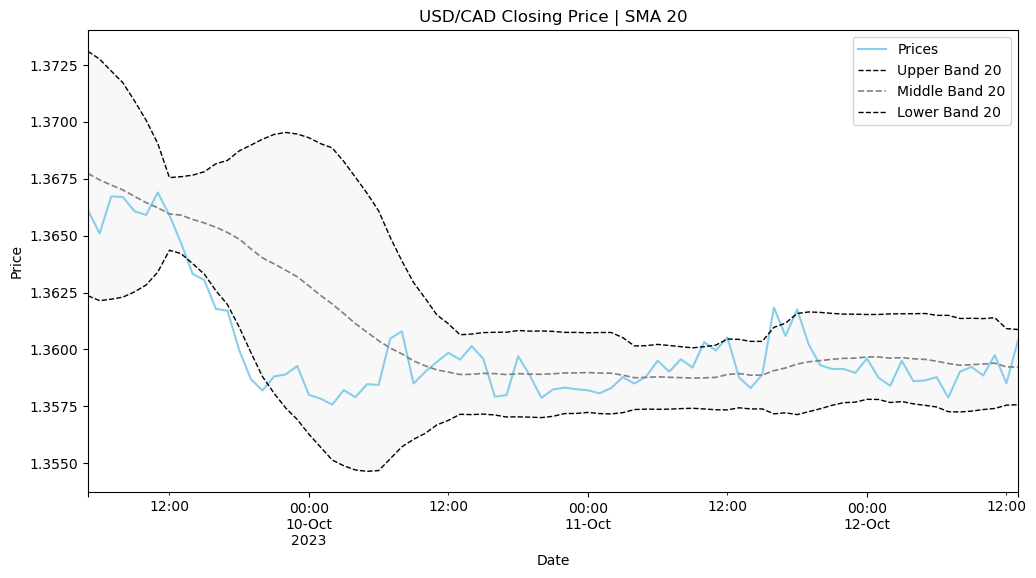

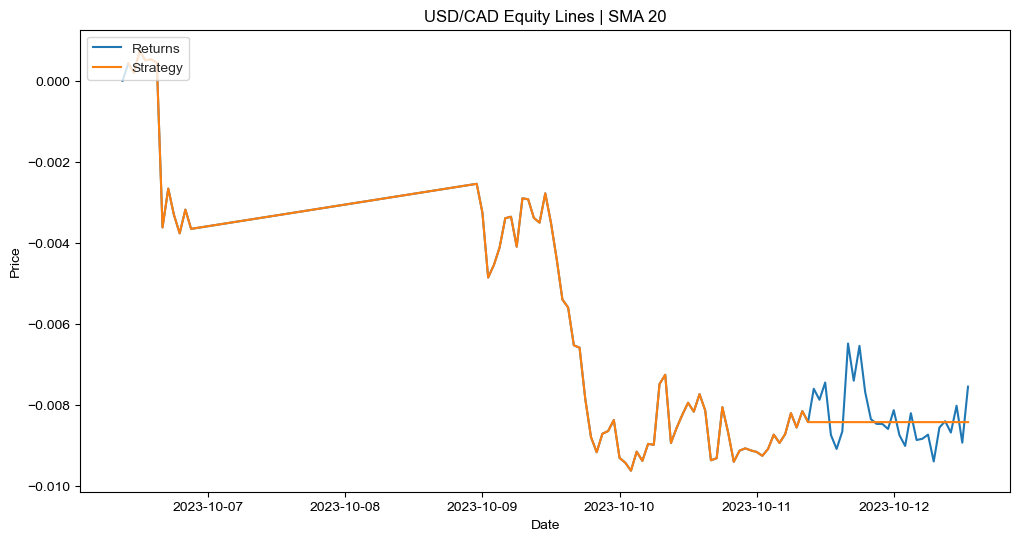

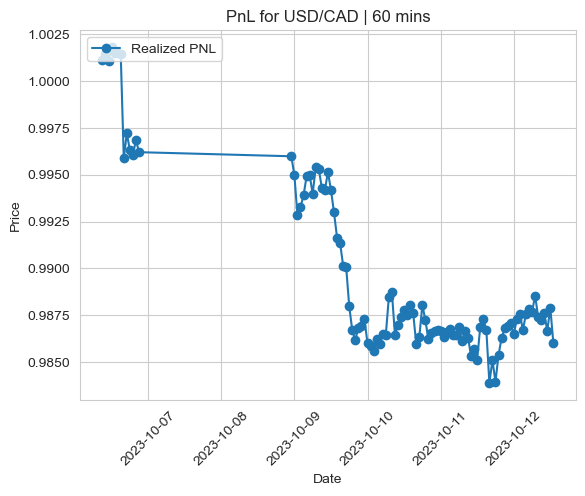

In [8]:
bb_backtest_strategy(f"{from_symbol}/{to_symbol}", pricing_df, 'timestamp', 'close', param_window = sma_window, param_std = std)

### Parameter Sensitivity Analysis

For this strategy, we will focus on the hyperparameters below:
    
- Simple Moving Average (SMA) Window
- Standard Deviation

In [9]:
def indicator(data, sma_window, std):
    bbands = ta.bbands(close = data.Close.s, length = sma_window, std = std)
    return bbands.to_numpy().T[:3]

In [10]:
class BollingerBandsStrategy(Strategy):
    
    std_cust = std
    sma_window_cust = sma_window
    
    def init(self):
        self. bbands = self.I(indicator, self.data, self.std_cust, self.sma_window_cust)

    def next(self):
        lower_band = self.bbands[0]
        upper_band = self.bbands[2]
        
        if self.position:
            if self.data.Close[-1] > upper_band[-1]:
                self.position.close()
        else:
            if self.data.Close[-1] > lower_band[-1]:
                self.buy()

In [11]:
pricing_df_rename = pricing_df.rename(columns = {'open':'Open', 'high':'High', 'low':'Low', 'close':'Close'})

In [14]:
# Create an instance of the Backtest class and run the backtest

bt = Backtest(pricing_df_rename, BollingerBandsStrategy, cash=10000, commission=0.001)
stats = bt.run()

In [15]:
print(stats)

Start                     2023-10-06 09:00:00
End                       2023-10-12 13:00:00
Duration                      6 days 04:00:00
Exposure Time [%]                        97.0
Equity Final [$]                  9899.081833
Equity Peak [$]                       10000.0
Return [%]                          -1.009182
Buy & Hold Return [%]                -0.75217
Return (Ann.) [%]                  -19.932059
Volatility (Ann.) [%]                3.511439
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -1.076213
Avg. Drawdown [%]                   -1.076213
Max. Drawdown Duration        6 days 02:00:00
Avg. Drawdown Duration        6 days 02:00:00
# Trades                                    1
Win Rate [%]                              0.0
Best Trade [%]                      -1.009295
Worst Trade [%]                     -1.009295
Avg. Trade [%]                    

In [17]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,7286,3,99,1.372341,1.35849,-100.918167,-0.010093,2023-10-06 12:00:00,2023-10-12 13:00:00,6 days 01:00:00


In [18]:
stats, heatmap = bt.optimize(
    sma_window_cust = range(20, 50, 5),
    std_cust = range(2, 10, 1),
    maximize = "Equity Final [$]",
    return_heatmap = True
)

hm = heatmap.groupby(["sma_window_cust", "std_cust"]).mean().unstack()

  0%|          | 0/12 [00:00<?, ?it/s]

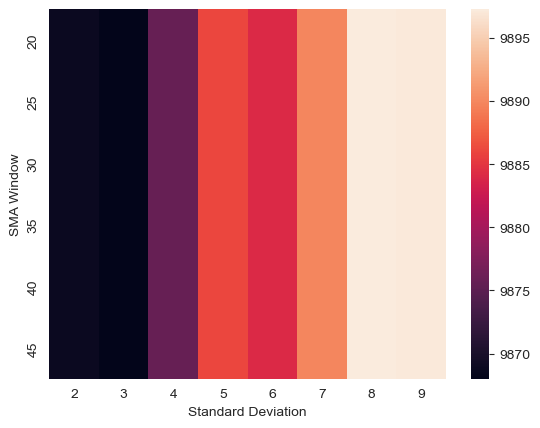

In [19]:
pricing_hm = sns.heatmap(hm)
pricing_hm.set(xlabel='Standard Deviation', ylabel='SMA Window')
plt.show()